In [19]:
import os
import cv2
import dlib
import numpy as np
import argparse
from contextlib import contextmanager
from wide_resnet import WideResNet
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt

In [20]:
pretrained_model = "/home/neosai/Documents/projects/predict_age_gender/weights/weights.29-3.76_utk.hdf5"
pretrained_model = ""

In [21]:
def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=1, thickness=2):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness)

In [22]:
depth = 16
k = 8
margin = 0.4
img_size = 64

detector = dlib.get_frontal_face_detector()

model = WideResNet(img_size, depth=depth, k=k)()
model.load_weights(pretrained_model)

In [33]:
img = cv2.imread("../data/test/images.jpeg")

2


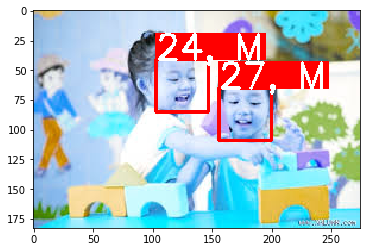

In [34]:
input_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_h, img_w, _ = np.shape(input_img)

detected = detector(input_img, 1)
faces = np.empty((len(detected), img_size, img_size, 3))
print(len(detected))
if len(detected) > 0:
    for i, d in enumerate(detected):
        x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()
        xw1 = max(int(x1 - margin * w), 0)
        yw1 = max(int(y1 - margin * h), 0)
        xw2 = min(int(x2 + margin * w), img_w - 1)
        yw2 = min(int(y2 + margin * h), img_h - 1)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # cv2.rectangle(img, (xw1, yw1), (xw2, yw2), (255, 0, 0), 2)
        faces[i, :, :, :] = cv2.resize(img[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))
        
    results = model.predict(faces)
    predicted_genders = results[0]
    ages = np.arange(0, 101).reshape(101, 1)
    predicted_ages = results[1].dot(ages).flatten()

    # draw results
    for i, d in enumerate(detected):
        label = "{}, {}".format(int(predicted_ages[i]),
                                "F" if predicted_genders[i][0] > 0.5 else "M")
        draw_label(img, (d.left(), d.top()), label)   
    
    plt.imshow(img)